In [89]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import tempfile

os.environ["OPENBLAS_NUM_THREADS"] = "1"

from IPython.display import HTML, display
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp

plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation
from tdgl import TDGLSolver,SolverResult
from tdgl.geometry import box
from tdgl.solver.runner import DataHandler, Runner
from tdgl.solution.solution import Solution
from tdgl.solver.options import SparseSolver
import itertools
import logging
logger = logging.getLogger("solver")
from datetime import datetime

from scipy.signal import find_peaks
#plt.rcParams['animation.ffmpeg_path'] = "C:\\FFmpeg\\bin\\ffmpeg"

np.set_printoptions(linewidth=100)

In [90]:
MAKE_ANIMATIONS = True
tempdir = tempfile.TemporaryDirectory()
tempdir

<TemporaryDirectory '/var/folders/t7/4qq067ln4xzfz0kchzzzlhkw0000gn/T/tmpxutrqv_i'>

In [91]:
def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

In [92]:
class TDGLSolverFluc(TDGLSolver):
    def __init__(self, device, options, applied_vector_potential = 0.0, terminal_currents =  None, disorder_epsilon = 1.0, seed_solution = None, T = 0):
        super().__init__(device, options, applied_vector_potential, terminal_currents,disorder_epsilon, seed_solution)
        self.T = T
    
    def therm_fluc(self):
        T= self.T
        therm =  np.zeros([len(self.sites),]) 
        if T==0:
            return therm
        sd = np.sqrt(4*5.79*np.sqrt(2)*10**(-4)*T/(1-T))

        therm =  np.array(np.random.normal(loc=0,scale=sd,size=[len(self.sites),]),dtype = 'complex')+\
                1j*np.array(np.random.normal(loc=0,scale=sd,size=[len(self.sites),]),dtype = 'complex')
        
        for t in self.terminal_info:
            therm[t.site_indices]=0
        return therm
    @staticmethod
    def solve_for_psi_squared(
        *,
        psi: np.ndarray,
        abs_sq_psi: np.ndarray,
        mu: np.ndarray,
        epsilon: np.ndarray,
        gamma: float,
        u: float,
        dt: float,
        T:float,
        therm:np.ndarray,
        psi_laplacian: sp.spmatrix,
    ):
        if isinstance(psi, np.ndarray):
            xp = np
        else:
            assert cupy is not None
            assert isinstance(psi, cupy.ndarray)
            xp = cupy
        U = xp.exp(-1j * mu * dt)
        z = U * gamma**2 / 2 * psi
        with np.errstate(all="raise"):
            try:
                w = z * abs_sq_psi + U * (
                    psi
                    + (dt / u)
                    * xp.sqrt(1 + gamma**2 * abs_sq_psi)
                    * ((epsilon - abs_sq_psi) * psi* (1-T)+therm + psi_laplacian @ psi)#modification
                )
                c = w.real * z.real + w.imag * z.imag
                two_c_1 = 2 * c + 1
                w2 = xp.absolute(w) ** 2
                discriminant = two_c_1**2 - 4 * xp.absolute(z) ** 2 * w2
            except Exception:
                logger.warning("Unable to solve for |psi|^2.", exc_info=True)
                return None
        if xp.any(discriminant < 0):
            return None
        new_sq_psi = (2 * w2) / (two_c_1 + xp.sqrt(discriminant))
        psi = w - z * new_sq_psi
        return psi, new_sq_psi

    def adaptive_euler_step(
        self,
        step: int,
        psi: np.ndarray,
        abs_sq_psi: np.ndarray,
        mu: np.ndarray,
        epsilon: np.ndarray,
        therm:np.ndarray,
        dt: float,
    ):
        options = self.options
        kwargs = dict(
            psi=psi,
            abs_sq_psi=abs_sq_psi,
            mu=mu,
            epsilon=epsilon,
            T=self.T,
            therm=therm,
            gamma=self.gamma,
            u=self.u,
            dt=dt,
            psi_laplacian=self.operators.psi_laplacian,
        )
        result = self.solve_for_psi_squared(**kwargs)
        for retries in itertools.count():
            if result is not None:
                break  # First evaluation of |psi|^2 was successful.
            if not options.adaptive or retries > options.max_solve_retries:
                raise RuntimeError(
                    f"Solver failed to converge in {options.max_solve_retries}"
                    f" retries at step {step} with dt = {dt:.2e}."
                    f" Try using a smaller dt_init."
                )
            kwargs["dt"] = dt = dt * options.adaptive_time_step_multiplier
            result = self.solve_for_psi_squared(**kwargs)
        psi, new_sq_psi = result
        return psi, new_sq_psi, dt

    def update(
        self,state,running_state,dt,*,psi,mu,supercurrent,normal_current,
        induced_vector_potential,applied_vector_potential = None,epsilon= None):
        xp = self.xp
        options = self.options
        operators = self.operators

        
        step = state["step"]
        time = state["time"]
        A_induced = induced_vector_potential
        prev_A_applied = A_applied = applied_vector_potential

        # Update the scalar potential boundary conditions.
        self.update_mu_boundary(time)

        # Update the applied vector potential.
        dA_dt = 0.0
        current_A_applied = self.current_A_applied
        if self.dynamic_vector_potential:
            current_A_applied = self.update_applied_vector_potential(time)
            dA_dt = xp.einsum(
                "ij, ij -> i",
                (current_A_applied - prev_A_applied) / dt,
                self.normalized_directions,
            )
            if xp.any(xp.absolute(dA_dt) > 0):
                # Update the link exponents only if the applied vector potential
                # has actually changed.
                operators.set_link_exponents(current_A_applied)
        else:
            assert A_applied is None
            prev_A_applied = A_applied = current_A_applied

        

        self.current_A_applied = current_A_applied

        # Update the value of epsilon
        epsilon = self.epsilon
        if self.dynamic_epsilon:
            epsilon = self.epsilon = self.update_epsilon(time)

        old_sq_psi = xp.absolute(psi) ** 2
        screening_error = np.inf
        A_induced_vals = [A_induced]
        velocity = [0.0]  # Velocity for Polyak's method
        # This loop runs only once if options.include_screening is False
        for screening_iteration in itertools.count():
            if screening_error < options.screening_tolerance:
                break
            if screening_iteration > options.max_iterations_per_step:
                raise RuntimeError(
                    f"Screening calculation failed to converge at step {step} after"
                    f" {options.max_iterations_per_step} iterations. Relative error in"
                    f" induced vector potential: {screening_error:.2e}"
                    f" (tolerance: {options.screening_tolerance:.2e})."
                )

            # Adjust the time step and calculate the new the order parameter
            if screening_iteration == 0:
                # Find a new time step only for the first screening iteration.
                dt = self.tentative_dt

            if options.include_screening:
                # Update the link variables in the covariant Laplacian and gradient
                # for psi based on the induced vector potential from the previous iteration.
                operators.set_link_exponents(current_A_applied + A_induced)

            # Update the order parameter using an adaptive time step
                
            therm = self.therm_fluc()
            psi, abs_sq_psi, dt = self.adaptive_euler_step(
                step, psi, old_sq_psi, mu, epsilon,therm, dt
            )
            # Update the scalar potential, supercurrent density, and normal current density
            mu, supercurrent, normal_current = self.solve_for_observables(psi, dA_dt)

            if options.include_screening:
                # Evaluate the induced vector potential
                A_induced, screening_error = self.get_induced_vector_potential(
                    supercurrent + normal_current, A_induced_vals, velocity
                )
            else:
                break
        
        running_state.append("dt", dt)
        if self.probe_points is not None:
            # Update the voltage and phase difference
            running_state.append("mu", mu[self.probe_points])
            running_state.append("theta", xp.angle(psi[self.probe_points]))
        if options.include_screening:
            running_state.append("screening_iterations", screening_iteration)

        if options.adaptive:
            # Compute the max abs change in |psi|^2, averaged over the adaptive window,
            # and use it to select a new time step.
            self.d_psi_sq_vals.append(float(xp.absolute(abs_sq_psi - old_sq_psi).max()))
            window = options.adaptive_window
            if step > window:
                new_dt = options.dt_init / max(
                    1e-10, np.mean(self.d_psi_sq_vals[-window:])
                )
                self.tentative_dt = np.clip(0.5 * (new_dt + dt), 0, self.dt_max)

        results = [dt, psi, mu, supercurrent, normal_current, A_induced]
        if self.dynamic_vector_potential:
            results.append(current_A_applied)
        if self.dynamic_epsilon:
            results.append(epsilon)
        return SolverResult(*results)

    def solve_for_observables(self, psi, dA_dt) :
        use_cupy = self.use_cupy
        options = self.options
        use_cupy_solver = options.sparse_solver is SparseSolver.CUPY
        operators = self.operators
        # Compute the supercurrent, scalar potential, and normal current
        supercurrent = (1-self.T)*operators.get_supercurrent(psi)
        rhs = (operators.divergence @ (supercurrent - dA_dt)) - (
            operators.mu_boundary_laplacian @ self.mu_boundary
        )
        if use_cupy and not use_cupy_solver:
            rhs = cupy.asnumpy(rhs)
        if self.options.sparse_solver is SparseSolver.PARDISO:
            mu = pypardiso.spsolve(operators.mu_laplacian, rhs)
        else:
            mu = operators.mu_laplacian_lu(rhs)
        if use_cupy and not use_cupy_solver:
            mu = cupy.asarray(mu)
        normal_current = -(operators.mu_gradient @ mu) - dA_dt
        return mu, supercurrent, normal_current

    def solve(self):
        start_time = datetime.now()
        options = self.options
        options.validate()
        output_file = options.output_file
        seed_solution = self.seed_solution
        num_edges = self.num_edges
        probe_points = self.probe_points

        # Set the initial conditions.
        if self.seed_solution is None:
            parameters = {
                "psi": self.psi_init,
                "mu": self.mu_init,
                "supercurrent": np.zeros(num_edges),
                "normal_current": np.zeros(num_edges),
                "induced_vector_potential": np.zeros((num_edges, 2)),
            }
        else:
            if self.seed_solution.device != self.device:
                raise ValueError(
                    "The seed_solution.device must be equal to the device being simulated."
                )
            seed_data = seed_solution.tdgl_data
            parameters = {
                "psi": seed_data.psi,
                "mu": seed_data.mu,
                # "T": self.T,#modification
                "supercurrent": seed_data.supercurrent,
                "normal_current": seed_data.normal_current,
                "induced_vector_potential": seed_data.induced_vector_potential,
            }

        fixed_values = []
        fixed_names = []
        if self.dynamic_vector_potential:
            parameters["applied_vector_potential"] = self.current_A_applied
        else:
            fixed_values.append(self.current_A_applied)
            fixed_names.append("applied_vector_potential")
        if self.dynamic_epsilon:
            parameters["epsilon"] = self.epsilon
        else:
            fixed_values.append(self.epsilon)
            fixed_names.append("epsilon")

        if self.use_cupy:
            # Move arrays to the GPU
            for key, val in parameters.items():
                parameters[key] = cupy.asarray(val)
            fixed_values = tuple(cupy.asarray(val) for val in fixed_values)

        running_names_and_sizes = {"dt": 1}
        if probe_points is not None:
            running_names_and_sizes["mu"] = len(probe_points)
            running_names_and_sizes["theta"] = len(probe_points)
        if options.include_screening:
            running_names_and_sizes["screening_iterations"] = 1

        with DataHandler(output_file=output_file, logger=logger) as data_handler:
            data_handler.save_mesh(self.device.mesh)
            if data_handler.tmp_file is not None:
                self.device.to_hdf5(
                    data_handler.tmp_file.create_group("solution/device")
                )
            logger.info(
                f"Simulation started at {start_time}"
                f" using sparse solver {options.sparse_solver.value!r}"
                f" and backend {('CuPy' if self.use_cupy else 'NumPy')!r}."
            )
            runner = Runner(
                function=self.update,
                options=options,
                data_handler=data_handler,
                monitor=options.monitor,
                monitor_update_interval=options.monitor_update_interval,
                initial_values=list(parameters.values()),
                names=list(parameters),
                fixed_values=tuple(fixed_values),
                fixed_names=tuple(fixed_names),
                running_names_and_sizes=running_names_and_sizes,
                logger=logger,
            )
            data_was_generated = runner.run()
            end_time = datetime.now()
            logger.info(f"Simulation ended at {end_time}")
            logger.info(f"Simulation took {end_time - start_time}")

            solution = None
            if data_was_generated:
                solution = Solution(
                    device=self.device,
                    path=data_handler.output_path,
                    options=options,
                    applied_vector_potential=self.applied_vector_potential,
                    terminal_currents=self.terminal_currents,
                    disorder_epsilon=self.disorder_epsilon,
                    total_seconds=(end_time - start_time).total_seconds(),
                )
                solution.to_hdf5()
            return solution

In [93]:
def solveFluc(device, options,applied_vector_potential = 0,terminal_currents= None,
    disorder_epsilon = 1,seed_solution = None,T=0):
    solver = TDGLSolverFluc(
        device=device,
        options=options,
        applied_vector_potential=applied_vector_potential,
        terminal_currents=terminal_currents,
        disorder_epsilon=disorder_epsilon,
        T=T,
        seed_solution=seed_solution
    )
    return solver.solve()

# KTO Weak Link on the left

## Define Device

In [94]:
length_units = "um"
# Material parameters
xi = 0.02
london_lambda = 2.5
d = 0.005
# Device geometry
total_width = 0.4
total_length = 1.2
# link_width = total_width / 2
# Outer geometry of the film
right_notch = (
    tdgl.Polygon(points=box(total_width,10.3*xi))
    .rotate(0)
    .translate(dx=2.5 * xi)
)
left_notch = (
    tdgl.Polygon(points=box(total_width,10.3*xi))
    .rotate(0)
    .translate(dx=-total_width)
)
# right_notch = left_notch.scale(xfact=-1)
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .difference(right_notch)
    .difference(left_notch)
    .resample(401)#resample vertices so that they are approximately uniformly distributed along the polygon boundary
    .buffer(0)
)
source = (
    tdgl.Polygon("source", points=box(.7 * total_width, total_length / 100))
    .translate(dy=total_length / 2)
)
drain = source.scale(yfact=-1).set_name("drain")
#  Voltage measurement points
probe_points = [(0, total_length/2-3*xi), (0, -total_length/2+3*xi)
                # ,(total_width/2-xi, total_length/2-3*xi), (total_width/2-xi, -total_length/2+3*xi)
                ]

In [ ]:
layer1 = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=0.0, u=5.79, conductivity=0.3)
device1 = tdgl.Device(
    "rectangle1",
    layer=layer1,
    film=film,
    #holes=[round_hole, square_hole],
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)

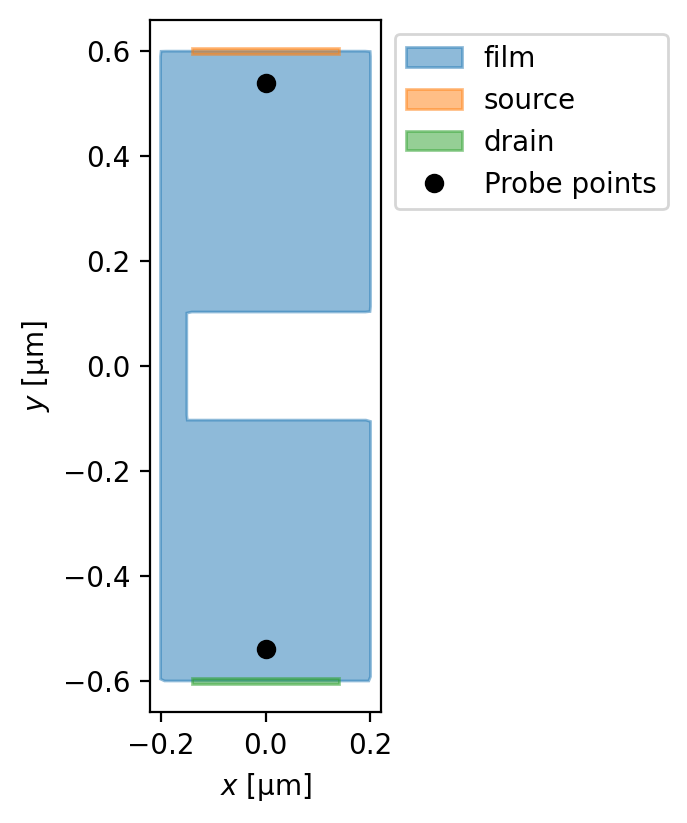

In [97]:
fig, ax = device1.draw()
fig.savefig('layout.pdf')

In [22]:
device1.make_mesh(max_edge_length=0.77*xi , smooth=100)

Constructing Voronoi polygons: 100%|██████████| 6039/6039 [00:00<00:00, 23306.26it/s]


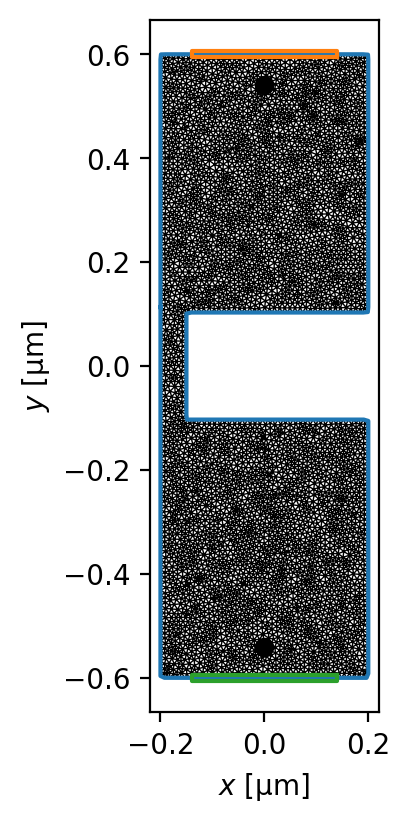

In [23]:
fig, ax = device1.plot(mesh=True, legend=False)
#_ = ax.set_ylim(-7, 7)

In [24]:
device1.mesh_stats()

## Solve for one current value

### Define Disorder

In [25]:
def dis(loc):
    # x,y=loc
    # if y < 5 * xi and y > -5 * xi:
    #     return .9
    return 1

In [ ]:
options = tdgl.SolverOptions(
    skip_time = 550,
    solve_time = 650,
    output_file = os.path.join(tempdir.name, "weak-link-positive-current.h5"),
    field_units = "mT",
    current_units = "uA",
    save_every = 100
)

solution1 = solveFluc(
    device1,
    options,
    terminal_currents=dict(source = .149, drain = -.149),
    applied_vector_potential = 200,
    disorder_epsilon = 1,
    T = 0.05
)

Simulating: 100%|██████████| 650/650 [03:25<00:00,  3.16tau/s ]


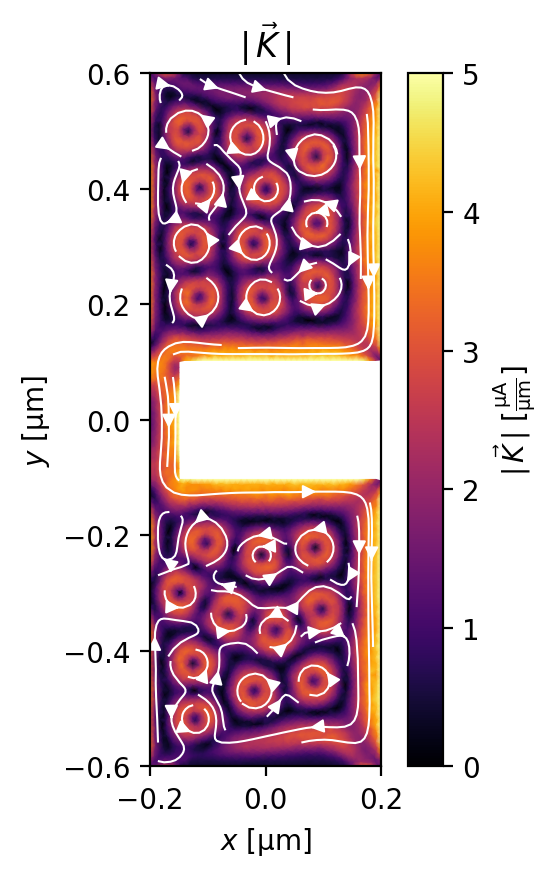

In [27]:
t0 = 100
solution1.solve_step = solution1.closest_solve_step(t0)
fig1, ax1 = solution1.plot_currents(min_stream_amp = 0.05, vmin = 0, vmax = 5, figsize = (3.5, 4.5))
# fig1.savefig('K150nA.pdf')

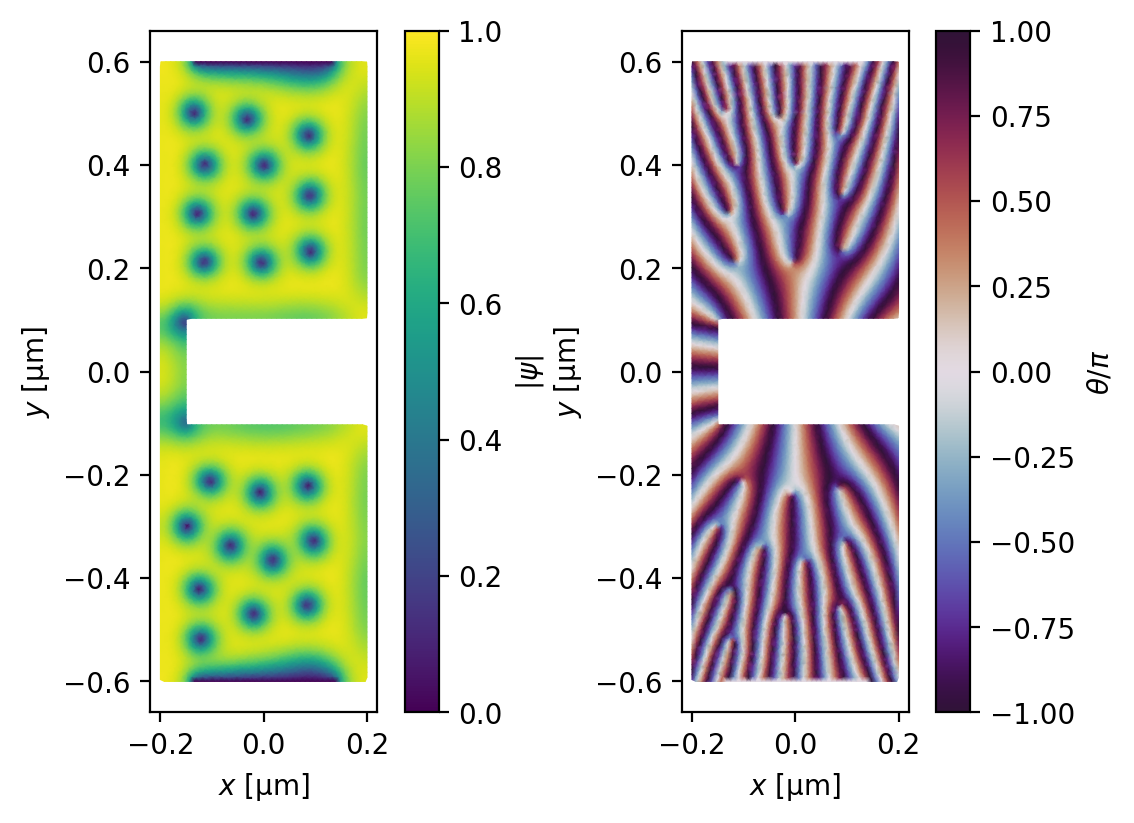

In [28]:
t0 = 100
solution1.solve_step = solution1.closest_solve_step(t0)
fig, axes = solution1.plot_order_parameter(figsize = (5.5, 4))

Text(0, 0.5, '$\\Delta \\phi/ \\pi$')

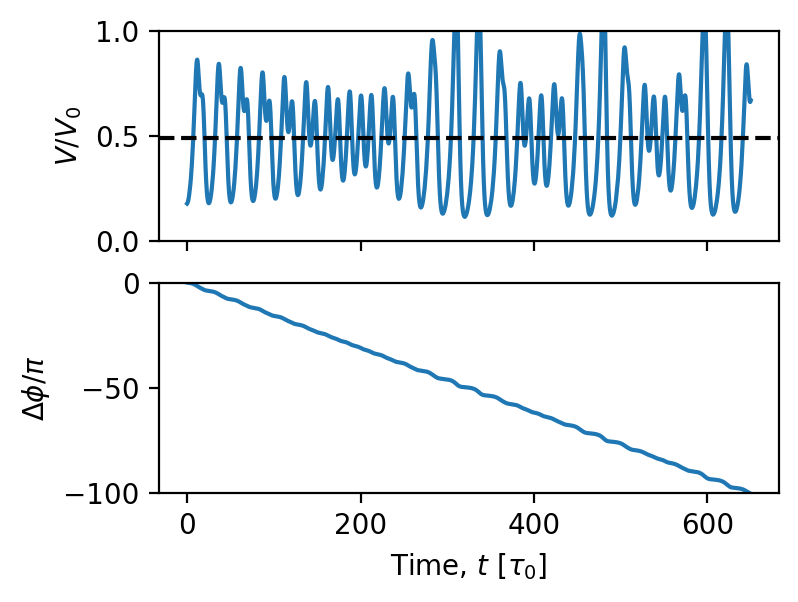

In [29]:
dynamics = solution1.dynamics
fig, axes = dynamics.plot(mean_voltage=True, tmax = 800, grid = False)


fig.set_size_inches((4, 3))
axes[0].set_ylim([-0, 1])
axes[1].set_ylim([-100, 0])
axes[0].set_ylabel('$V/V_0$')
axes[1].set_ylabel('$\Delta \phi/ \pi$')

In [30]:
dynamics.voltage().mean()

0.5200569186934022

In [31]:
if MAKE_ANIMATIONS:
    video1 = make_video_from_solution(
        solution1,
        quantities=['order_parameter', 'phase', 'scalar_potential'],
        figsize=(6.5, 4)
    )
    display(video1)

## Reverse Current

In [ ]:
options = tdgl.SolverOptions(
    skip_time = 550,
    solve_time = 650,
    output_file = os.path.join(tempdir.name, "weak-link-negative-current.h5"),
    field_units = "mT",
    current_units = "uA",
    save_every = 100
)

solution2 = solveFluc(
    device1,
    options,
    terminal_currents=dict(source = -.149, drain = .149),
    applied_vector_potential = 200,
    disorder_epsilon = 1,
    T=0.05
)

Simulating: 100%|█████████▉| 650/650 [01:35<00:00,  6.78tau/s ]


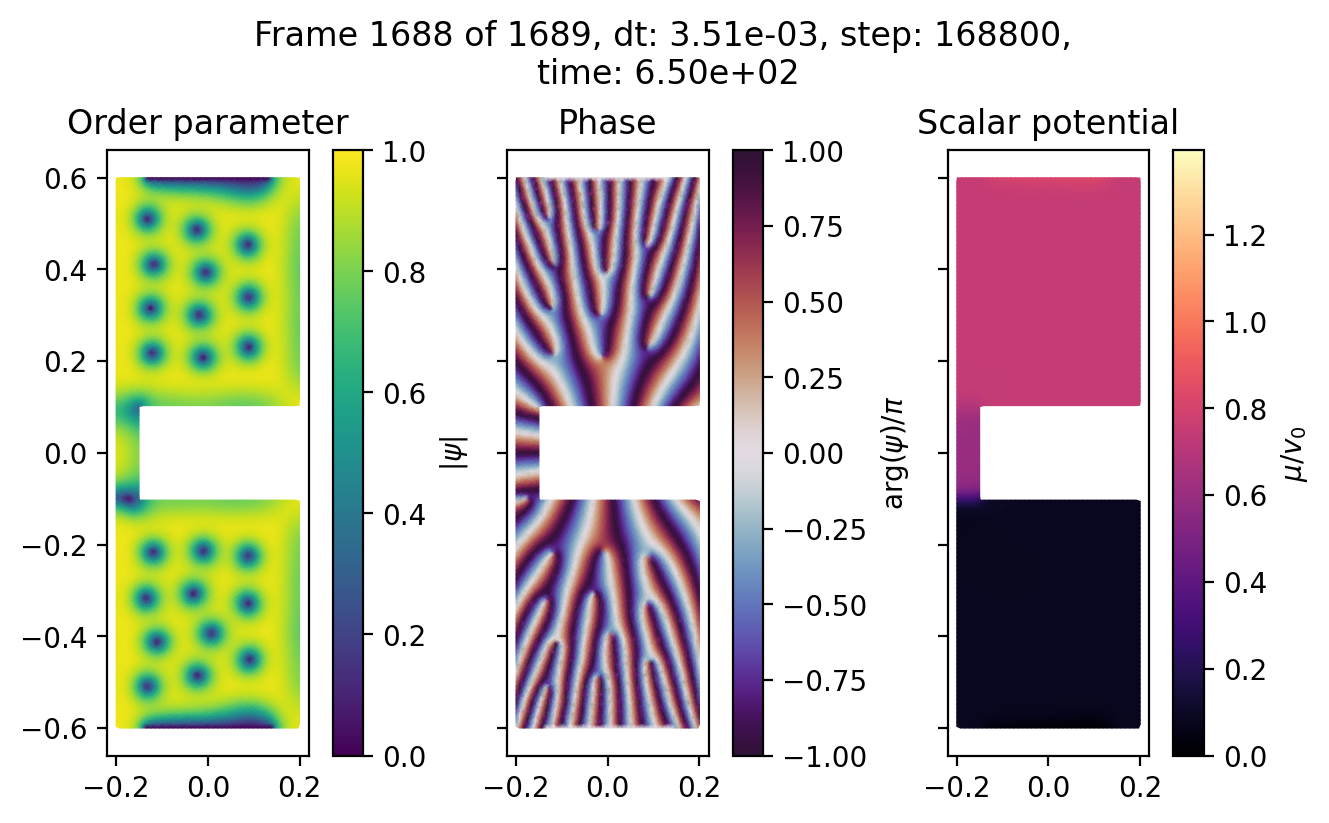

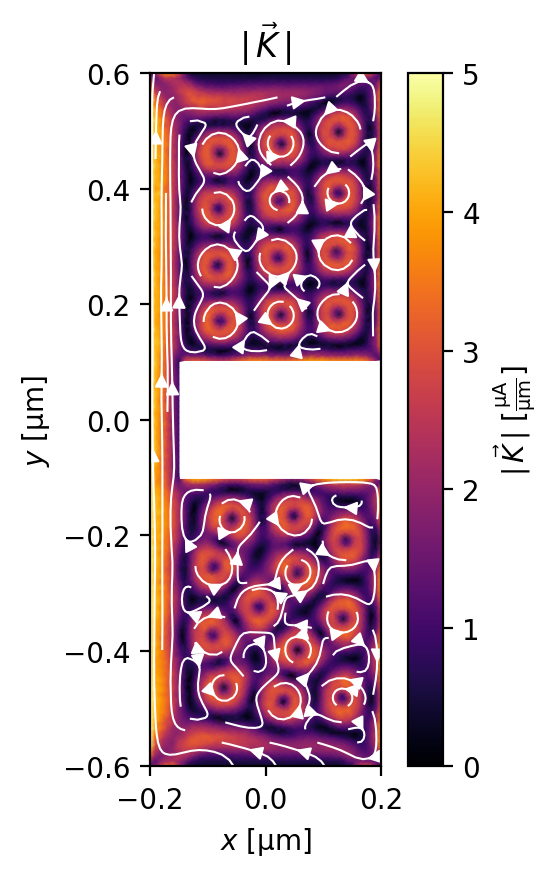

In [33]:
t0 = 100
solution2.solve_step = solution2.closest_solve_step(t0)
fig2, ax2 = solution2.plot_currents(min_stream_amp = 0.05, vmin = 0, vmax = 5, figsize = (3.5, 4.5))
# fig2.savefig('K-150nA.pdf')

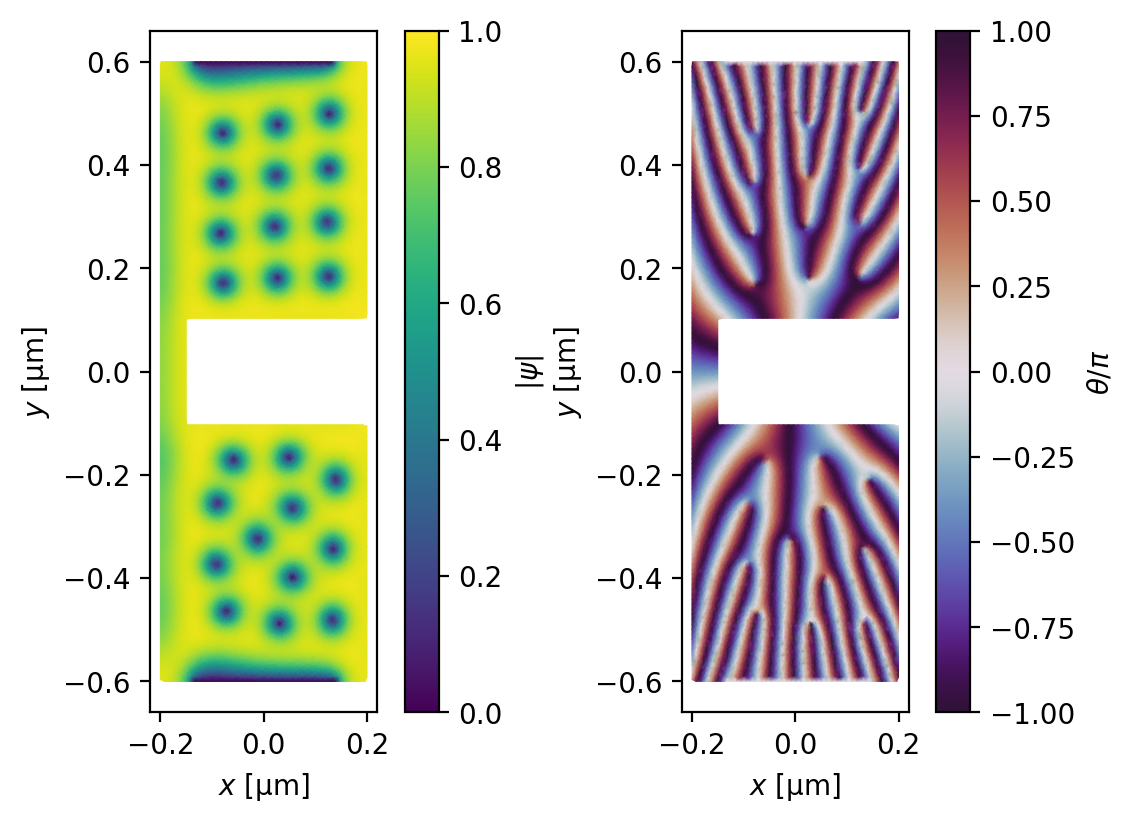

In [34]:
t0 = 100
solution2.solve_step = solution2.closest_solve_step(t0)
fig2, axes2 = solution2.plot_order_parameter(figsize = (5.5, 4))

Text(0, 0.5, '$\\Delta \\phi/ \\pi$')

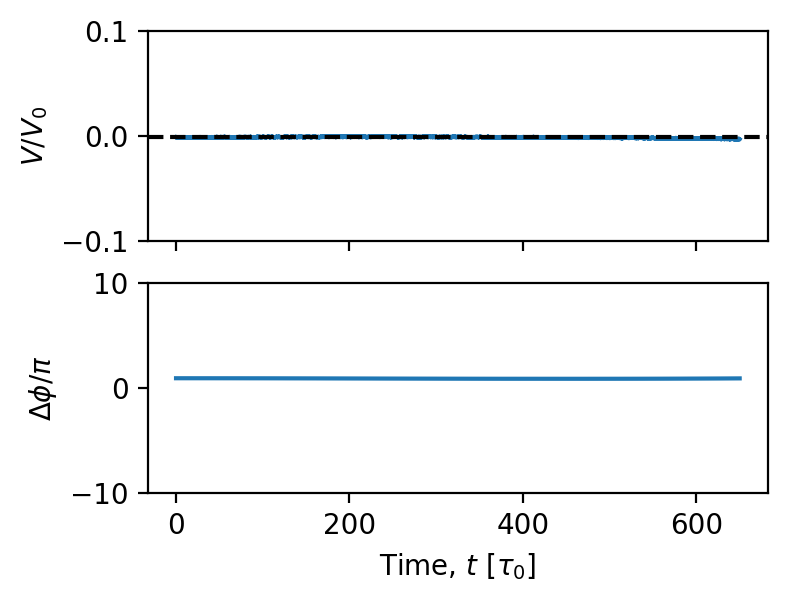

In [35]:
dynamics = solution2.dynamics
fig, axes = dynamics.plot(grid = False, tmax = 800)

fig.set_size_inches((4, 3))
axes[0].set_ylim([-.1, .1])
axes[1].set_ylim([-10, 10])
axes[0].set_ylabel('$V/V_0$')
axes[1].set_ylabel('$\Delta \phi/ \pi$')

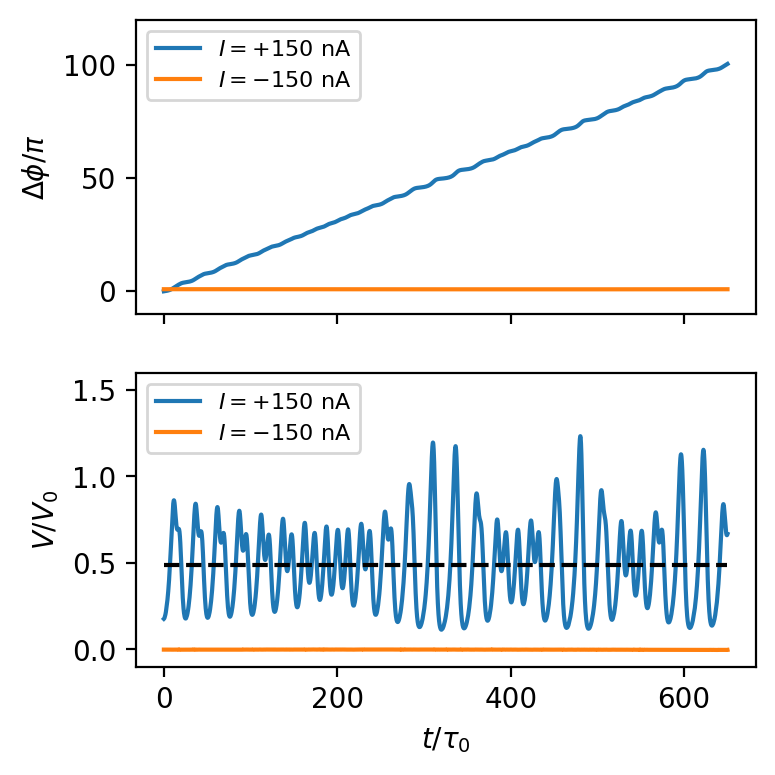

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (4, 4.2))
phases1 = np.unwrap(solution1.dynamics.phase_difference(0, 1)) / np.pi
phases2 = np.unwrap(solution2.dynamics.phase_difference(0, 1)) / np.pi

axes[1].plot(solution1.dynamics.time, solution1.dynamics.voltage())
axes[1].plot(solution2.dynamics.time, solution2.dynamics.voltage())
axes[1].hlines([solution1.dynamics.mean_voltage()], xmin = 0, xmax=650, color='k', linestyle='--')
axes[0].plot(solution1.dynamics.time, -phases1)
axes[0].plot(solution2.dynamics.time, -phases2)

axes[0].set_xticklabels([])
axes[1].set_ylim([-0.1, 1.6])
axes[0].set_ylim([-10, 120])
axes[1].set_ylabel('$V/V_0$')
axes[0].set_ylabel('$\Delta \phi/ \pi$')
axes[1].set_xlabel('$t/\\tau_0$')
axes[0].legend(['$I=+150$ nA', '$I=-150$ nA'], fontsize = 8)
axes[1].legend(['$I=+150$ nA', '$I=-150$ nA'], fontsize = 8)
# fig.savefig('Vphi.pdf', bbox_inches='tight')

In [37]:
if MAKE_ANIMATIONS:
    video2 = make_video_from_solution(
        solution2,
        quantities=['order_parameter', 'phase', 'scalar_potential'],
        figsize=(6.5, 4)
    )
    display(video2)

## Sweep B and current, save the calculated mean voltage in a dataframe

In [ ]:
current_list = np.append(np.linspace(-0.03, -0.21, 121), 0)
current_list = np.append(current_list, np.linspace(0.03, 0.21, 121))
VvsIvsB = pd.DataFrame({'current':current_list})

for B in range(-600, 601, 25):
    voltage_list = np.array([])

    options0 = tdgl.SolverOptions(
        skip_time = 160,
        solve_time = 90,
        output_file = os.path.join(tempdir.name, f"left-weak-link-{B}mT-field.h5"),
        field_units = "mT",
        current_units = "uA",
        save_every = 800
    )

    seed_solution = solveFluc(
        device1,
        options0,
        terminal_currents=dict(source = current_list[0], drain = -current_list[0]),
        applied_vector_potential = B,
        disorder_epsilon = 1,
        T=0.05

    )

    options1 = tdgl.SolverOptions(
        skip_time = 80,
        solve_time = 90,
        output_file = os.path.join(tempdir.name, f"left-weak-link-{B}mT-field.h5"),
        field_units = "mT",
        current_units = "uA",
        save_every = 800
    )

    for current in current_list:
        if current == 0:
            solution = solveFluc(
                device1,
                options0,
                terminal_currents=dict(source = 0, drain = 0),
                applied_vector_potential = B,
                disorder_epsilon = 1,
                T=0.05
            )
        else:
            solution = solveFluc(
                device1,
                options1,
                terminal_currents=dict(source = current, drain = -current),
                applied_vector_potential = B,
                disorder_epsilon = 1,
                T=0.05,
                seed_solution = seed_solution
            )
        mean_voltage = solution.dynamics.voltage().mean()
        voltage_list = np.append(voltage_list, mean_voltage)
        seed_solution = solution
    
    VvsIvsB[str(B)] = voltage_list
    VvsIvsB.to_csv('left-weak-link-VvsIvsB-all.csv')

VvsIvsB.set_index('current', inplace = True)
VvsIvsB.sort_index(inplace=True, ascending=True)
VvsIvsB.to_csv('left-weak-link-VvsIvsB-all.csv')

In [7]:
VvsIvsB=pd.read_csv('left-weak-link-VvsIvsB-all.csv')

In [8]:
VvsIvsB.set_index('current', inplace = True)

In [9]:
VvsIvsB.columns = [str(-10*int(B)) for B in VvsIvsB.columns]

In [10]:
VvsIvsB

6000      5750      5500      5250      5000      4750      4500  \
current                                                                         
-0.2100 -7.489083 -7.353378 -7.198888 -7.049657 -6.956890 -6.832759 -6.676498   
-0.2085 -7.403089 -7.316020 -7.103550 -7.050249 -6.929367 -6.786485 -6.663153   
-0.2070 -7.358066 -7.212180 -7.078178 -6.968891 -6.859626 -6.750582 -6.653704   
-0.2055 -7.276634 -7.142041 -6.999399 -6.870666 -6.802147 -6.732413 -6.555806   
-0.2040 -7.228396 -7.087922 -6.948247 -6.819590 -6.736498 -6.656422 -6.477728   
...           ...       ...       ...       ...       ...       ...       ...   
 0.2040  7.538037  7.397271  7.246404  7.089476  6.901987  6.752383  6.568690   
 0.2055  7.613299  7.461467  7.305644  7.158823  6.965725  6.816353  6.704670   
 0.2070  7.684054  7.537490  7.371600  7.190213  7.050668  6.885570  6.697428   
 0.2085  7.735781  7.634439  7.397587  7.239758  7.085809  6.875433  6.738640   
 0.2100  7.788068  7.688547  7.459785  7.338636  7.118479  6.940617  6.795160   

             4250      4000      3750  ...     -3750     -4000     -4250  \
current                                ...                                 
-0.2100 -6.548022 -6.383048 -6.291226  ... -6.333090 -6.544280 -6.639346   
-0.2085 -6.526472 -6.340772 -6.232250  ... -6.278155 -6.501143 -6.561670   
-0.2070 -6.457864 -6.318091 -6.258087  ... -6.351901 -6.397633 -6.553225   
-0.2055 -6.443698 -6.301885 -6.212893  ... -6.146481 -6.263730 -6.552621   
-0.2040 -6.356351 -6.242020 -5.989866  ... -6.094201 -6.223747 -6.387008   
...           ...       ...       ...  ...       ...       ...       ...   
 0.2040  6.414668  6.310705  6.228568  ...  6.166145  6.233788  6.336223   
 0.2055  6.466895  6.445717  6.086954  ...  6.156606  6.166215  6.407796   
 0.2070  6.538624  6.359704  6.320979  ...  6.306579  6.289496  6.520417   
 0.2085  6.572723  6.434854  6.272381  ...  6.323934  6.363454  6.589250   
 0.2100  6.727297  6.470257  6.334461  ...  6.307513  6.407226  6.626343   

            -4500     -4750     -5000     -5250     -5500     -5750     -6000  
current                                                                        
-0.2100 -6.836337 -7.056430 -7.132112 -7.334621 -7.479585 -7.687699 -7.812150  
-0.2085 -6.780957 -7.011418 -7.085031 -7.274300 -7.420032 -7.621972 -7.760506  
-0.2070 -6.730847 -6.936158 -7.010800 -7.199450 -7.324115 -7.531027 -7.668675  
-0.2055 -6.648185 -6.801019 -6.957710 -7.109040 -7.271910 -7.467815 -7.610634  
-0.2040 -6.573401 -6.739505 -6.954952 -7.062991 -7.233212 -7.413669 -7.538437  
...           ...       ...       ...       ...       ...       ...       ...  
 0.2040  6.493396  6.613922  6.793429  6.856701  6.979254  7.099880  7.198379  
 0.2055  6.613418  6.692050  6.836352  6.912638  7.004422  7.162088  7.262820  
 0.2070  6.614887  6.728515  6.863330  6.949681  7.096695  7.205976  7.339599  
 0.2085  6.765727  6.770534  6.923887  7.035789  7.156418  7.288111  7.421658  
 0.2100  6.783421  6.820293  6.982524  7.112047  7.222625  7.333088  7.480981  

[243 rows x 49 columns]

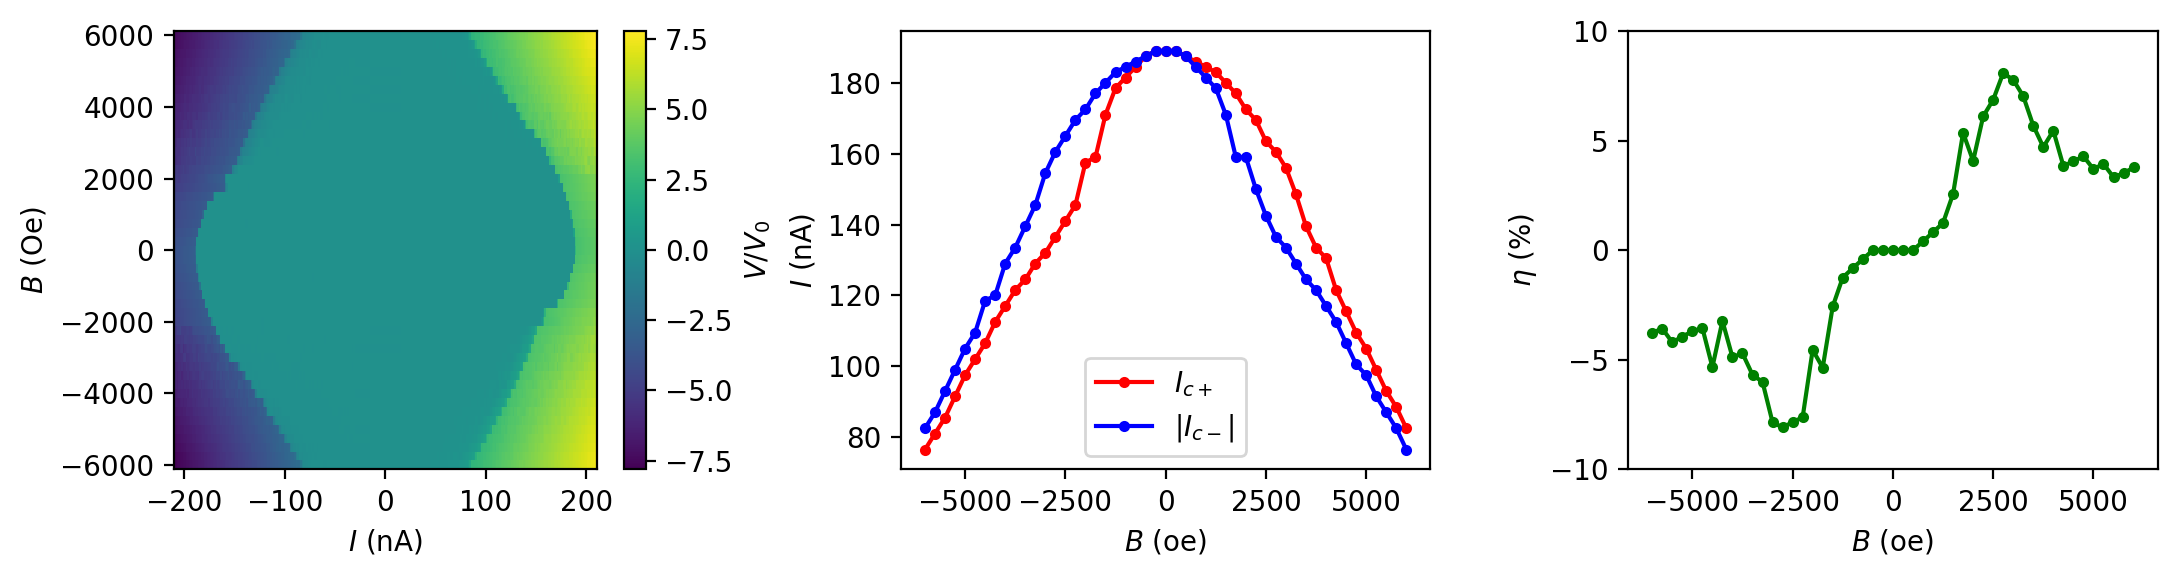

In [84]:
fig, axes = plt.subplots(1, 3, figsize = (11, 3))
Icm_list = np.array([])
Icp_list = np.array([])
B_list = np.array([])

for i, B in enumerate(VvsIvsB.columns[::]):
    VvsI = VvsIvsB[B]
    for I in VvsI.index:
        if VvsI.loc[I] >= 0.5:
            Icp = I
            break
    VvsI = VvsI.iloc[::-1]
    for I in VvsI.index:
        if VvsI.loc[I] <= -0.5:
            Icm = I
            break
    B_list = np.append(B_list, int(B))
    Icm_list = np.append(Icm_list, Icm)
    Icp_list = np.append(Icp_list, Icp)
#     axes[0].plot(VvsI.index, VvsI.values + 2 * i, label = B + ' mT', color = [i / 48, 0, 1- i /48])
# axes[0].set_xlabel('I (uA)')
# axes[0].set_ylabel('V (V0)')

df_transposed = VvsIvsB.T
x_axis_nA = df_transposed.columns * 1000
y_axis_Oe = B_list
z_values = df_transposed.values

# Create the intensity plot (pcolormesh is great for this)
# Note: Shading='auto' helps if dimensions don't perfectly match
im = axes[0].pcolormesh(x_axis_nA, y_axis_Oe, z_values, shading='auto', cmap='viridis')

# Add a color bar
cbar = fig.colorbar(im, ax=axes[0])
cbar.set_label('$V/V_0$') # Replace with your Z-axis unit/name

# Set labels and title
axes[0].set_xticks([-200,-100,0,100,200])
axes[0].set_xlabel('$I$ (nA)')
axes[0].set_ylabel('$B$ (Oe)')
# axes[0].set_title('Intensity Plot')

# axes[1].plot(VvsIvsB.iloc[::, 16].index*1000, VvsIvsB.iloc[::, 16].values, label = '$B=$'+VvsIvsB.columns[16]+' oe')
# axes[1].plot(VvsIvsB.iloc[::, 24].index*1000, VvsIvsB.iloc[::, 24].values, label = '$B=$'+VvsIvsB.columns[24]+' oe')
# axes[1].plot(VvsIvsB.iloc[::, -17].index*1000, VvsIvsB.iloc[::, -17].values, label = '$B=$'+VvsIvsB.columns[-17]+' oe')
# axes[1].set_xticks([-200,-100,0,100,200])
# axes[1].set_xlabel('$I$ (nA)')
# axes[1].set_ylabel('')
# axes[1].legend()

axes[1].plot(B_list, Icp_list * 1000, 'ro-', markersize = 3, label = '$I_{c+}$')
axes[1].plot(B_list, -Icm_list * 1000, 'bo-', markersize = 3, label = '$|I_{c-}|$')
axes[1].set_xlabel('$B$ (oe)')
axes[1].set_ylabel('$I$ (nA)')
# axes[1].hlines([0.175], xmin = -175, xmax = 175, color='k')
axes[1].legend()

axes[2].plot(B_list, (Icp_list+Icm_list) / (Icp_list-Icm_list) * 100, 'go-', markersize = 3)
axes[2].set_ylim([-10, 10])
axes[2].set_xlabel('$B$ (oe)')
axes[2].set_ylabel('$\eta$ (%)')

plt.tight_layout()
fig.savefig('VIB.pdf', bbox_inches='tight')

In [86]:
pd.Series((Icp_list+Icm_list) / (Icp_list-Icm_list) * 100, index=B_list).idxmin()

-2750.0

In [87]:
Icp_list.max()

0.189